# Challenge: Backtest on Other Datasets

## Download data from `yfinance`

In [80]:
import yfinance as yf

In [81]:
df = yf.download(tickers='NFLX')
df.columns = df.columns.get_level_values(0)  # reset multiindexing
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2002-05-23,1.196429,1.242857,1.145714,1.156429,104790000
2002-05-24,1.210000,1.225000,1.197143,1.214286,11104800
2002-05-28,1.157143,1.232143,1.157143,1.213571,6609400
2002-05-29,1.103571,1.164286,1.085714,1.164286,6757800
2002-05-30,1.071429,1.107857,1.071429,1.107857,10154200
...,...,...,...,...,...
2025-03-18,929.979980,948.250000,916.299988,940.000000,6009400
2025-03-19,959.489990,968.000000,924.000000,935.770020,6662400
2025-03-20,950.840027,967.000000,945.500000,950.010010,4466300


## Preprocess the data

### Filter the date range

- Since 1 year ago at least

In [82]:
df_year = df.loc['2024-02-01':, :].copy()
df_year

Price,Close,High,Low,Open,Volume
Date,,,,,
2024-02-01,567.510010,572.659973,563.830017,567.020020,3174000
2024-02-02,564.640015,567.799988,562.369995,564.520020,4030800
2024-02-05,562.059998,575.750000,557.200012,562.469971,4143100
2024-02-06,555.880005,566.340027,554.369995,564.119995,2840300
2024-02-07,559.299988,567.799988,554.979980,558.159973,4373600
...,...,...,...,...,...
2025-03-18,929.979980,948.250000,916.299988,940.000000,6009400
2025-03-19,959.489990,968.000000,924.000000,935.770020,6662400
2025-03-20,950.840027,967.000000,945.500000,950.010010,4466300


### Create the target variable

#### Percentage change

- Percentage change on `Adj Close` for tomorrow

In [83]:
df_year['change_tomorrow'] = df_year.Close.pct_change(-1)*100*-1
df_year

Price,Close,High,Low,Open,Volume,change_tomorrow
Date,,,,,,
2024-02-01,567.510010,572.659973,563.830017,567.020020,3174000,-0.508288
2024-02-02,564.640015,567.799988,562.369995,564.520020,4030800,-0.459029
2024-02-05,562.059998,575.750000,557.200012,562.469971,4143100,-1.111749
2024-02-06,555.880005,566.340027,554.369995,564.119995,2840300,0.611476
2024-02-07,559.299988,567.799988,554.979980,558.159973,4373600,-0.137854
...,...,...,...,...,...,...
2025-03-18,929.979980,948.250000,916.299988,940.000000,6009400,3.075593
2025-03-19,959.489990,968.000000,924.000000,935.770020,6662400,-0.909718
2025-03-20,950.840027,967.000000,945.500000,950.010010,4466300,0.984073


#### Drop rows with any missing data

<Axes: >

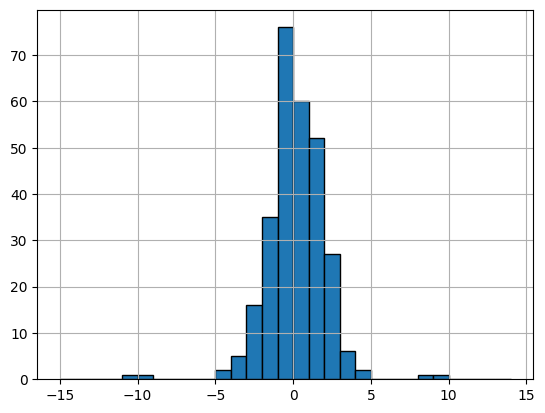

In [84]:
df_year = df_year.dropna().copy()
df_year.change_tomorrow.hist(bins=range(-15, 15), edgecolor='black')

#### Change sign

Did the stock go up or down?

In [85]:
import numpy as np

In [86]:
df_year['change_tomorrow_direction'] = np.where(df_year.change_tomorrow > 0, 1, -1)
df_year.change_tomorrow_direction.value_counts()

change_tomorrow_direction
 1    148
-1    137
Name: count, dtype: int64

## Compute Machine Learning model

Proposal: Random Forest within `ensemble` module of `sklearn` library

In [87]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
model = RandomForestClassifier(max_depth=7, random_state=42)
y = df_year.change_tomorrow_direction
X = df_year.drop(columns='change_tomorrow_direction')
model.fit(X, y)

RandomForestClassifier(max_depth=7, random_state=42)

In [89]:
model.score(X, y)

1.0

## Backtesting

### Create the Strategy

In [90]:
from backtesting import Backtest, Strategy

In [91]:
class SimpleClassificationUD(Strategy):
    def init(self):
        self.model = model
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[-1:, :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]

        # conditions to sell or buy
        if forecast_tomorrow == 1 and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow == -1 and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Run the Backtest

In [92]:
bt = Backtest(
    X, SimpleClassificationUD, cash=10000,
    commission=.002, exclusive_orders=True
)
results = bt.run()

### Show the report in a DataFrame

In [93]:
results.to_frame('Value').loc[:'Return [%]']

,Value
Start,2024-02-01 00:00:00
End,2025-03-21 00:00:00
Duration,414 days 00:00:00
Exposure Time [%],98.596491
Equity Final [$],103283.25997
Equity Peak [$],103283.25997
Commissions [$],20073.678591
Return [%],932.8326


## Plot the backtest report

> Don't worry about this new tool just yet, we will explain in a future chapter how to interpret the following chart.

In [95]:
bt.plot(filename='backtest_report.html')

GridPlot(id='p2035', ...)

## How to invest based on the numerical increase?

> Instead of the direction (UP or DOWN)

Next chapter → [Backtesting with Regression Models]()

Classification Model | Regression Model
-|-
![](src/pred_classification.png) | ![](src/pred_regression.png)

Classification Strategy | Regression Strategy
-|-
![](src/res_classification.png) | ![](src/res_regression.png)